In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Load data
df = pd.read_csv(r'UCI-electricity/UCI_data.csv')

# General overview upon the df
print('\n____________ Dataset info ____________')
display(df.info())              
print('\n____________ Statistics of numeric features ____________')
display(df.describe()) 
print('\n____________ Some first data examples ____________')
df.head(5)


____________ Dataset info ____________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           19735 non-null  object 
 1   T1             19735 non-null  float64
 2   RH_1           19735 non-null  float64
 3   T2             19735 non-null  float64
 4   RH_2           19735 non-null  float64
 5   T3             19735 non-null  float64
 6   RH_3           19735 non-null  float64
 7   T4             19735 non-null  float64
 8   RH_4           19735 non-null  float64
 9   T5             19735 non-null  float64
 10  RH_5           19735 non-null  float64
 11  T6             19735 non-null  float64
 12  RH_6           19735 non-null  float64
 13  T7             19735 non-null  float64
 14  RH_7           19735 non-null  float64
 15  T8             19735 non-null  float64
 16  RH_8           19735 non-null  float64
 17  T9        

None


____________ Statistics of numeric features ____________


,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,TARGET_energy
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,...,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033,101.496833
std,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,...,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634,104.380829
min,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,...,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,10.000000
25%,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,...,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889,50.000000
50%,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,...,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653,60.000000
75%,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,...,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769,100.000000
max,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,...,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530,1110.000000



____________ Some first data examples ____________


,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,TARGET_energy
0,2016-04-19 20:30:00,22.200000,39.500000,20.566667,37.656667,22.230000,37.030000,22.318571,36.610000,20.633333,...,33.90,9.70,766.100000,65.5,3.500000,40.000000,3.350000,24.061869,24.061869,60
1,2016-03-05 04:40:00,20.356667,37.126667,17.566667,40.230000,20.890000,37.663333,18.700000,36.260000,18.463333,...,41.09,0.30,740.333333,99.0,1.000000,41.333333,0.100000,4.622052,4.622052,50
2,2016-03-14 12:40:00,20.926667,38.790000,21.100000,35.526667,21.600000,36.290000,21.000000,34.826667,18.100000,...,38.76,4.40,768.466667,72.0,6.000000,22.666667,-0.266667,5.635898,5.635898,80
3,2016-01-22 15:30:00,18.290000,38.900000,17.290000,39.260000,18.390000,39.326667,16.100000,38.790000,16.100000,...,39.20,3.35,760.600000,82.0,5.500000,41.000000,0.500000,49.216445,49.216445,40
4,2016-02-10 00:40:00,22.290000,42.333333,21.600000,40.433333,22.666667,43.363333,19.100000,40.900000,19.290000,...,43.73,3.20,738.900000,88.0,7.333333,56.000000,1.400000,47.617579,47.617579,60


In [37]:
def plot_all_histograms_grid(font_scale=1.5, single_figsize=(5, 3), tick_label_size=10, color='c', n_cols=3):
    """
    Plot histograms for all numerical columns in a grid layout without hue.

    Parameters:
    - font_scale: float, scale factor for font size
    - single_figsize: tuple, size of the each figure (width, height)
    - tick_label_size: int, size of the tick labels
    - color: histogram color
    - n_cols: int, number of columns in the grid
    
    """
    sns.set(font_scale=font_scale)
    numerical_columns = df.select_dtypes(include='number').columns
    n_rows = (len(numerical_columns) + n_cols - 1) // n_cols  # Calculate the number of rows needed
    
     # Adjust figsize based on number of rows and columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(single_figsize[0] * n_cols, single_figsize[1] * n_rows))
    axes = axes.flatten()  # Flatten the 2D array of axes
    
    for i, column in enumerate(numerical_columns):
        sns.histplot(data=df, x=column, color=color, ax=axes[i], kde=True)
        axes[i].set_title(f'{column}')
        axes[i].set_xlabel(f'{column}')
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='both', labelsize=tick_label_size)
        axes[i].axvline(df[column].mean(), color='r', linestyle='--', label='Mean', linewidth=2)
        axes[i].axvline(df[column].median(), color='g', linestyle='-', label='Median', linewidth=2)
        axes[i].legend()

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

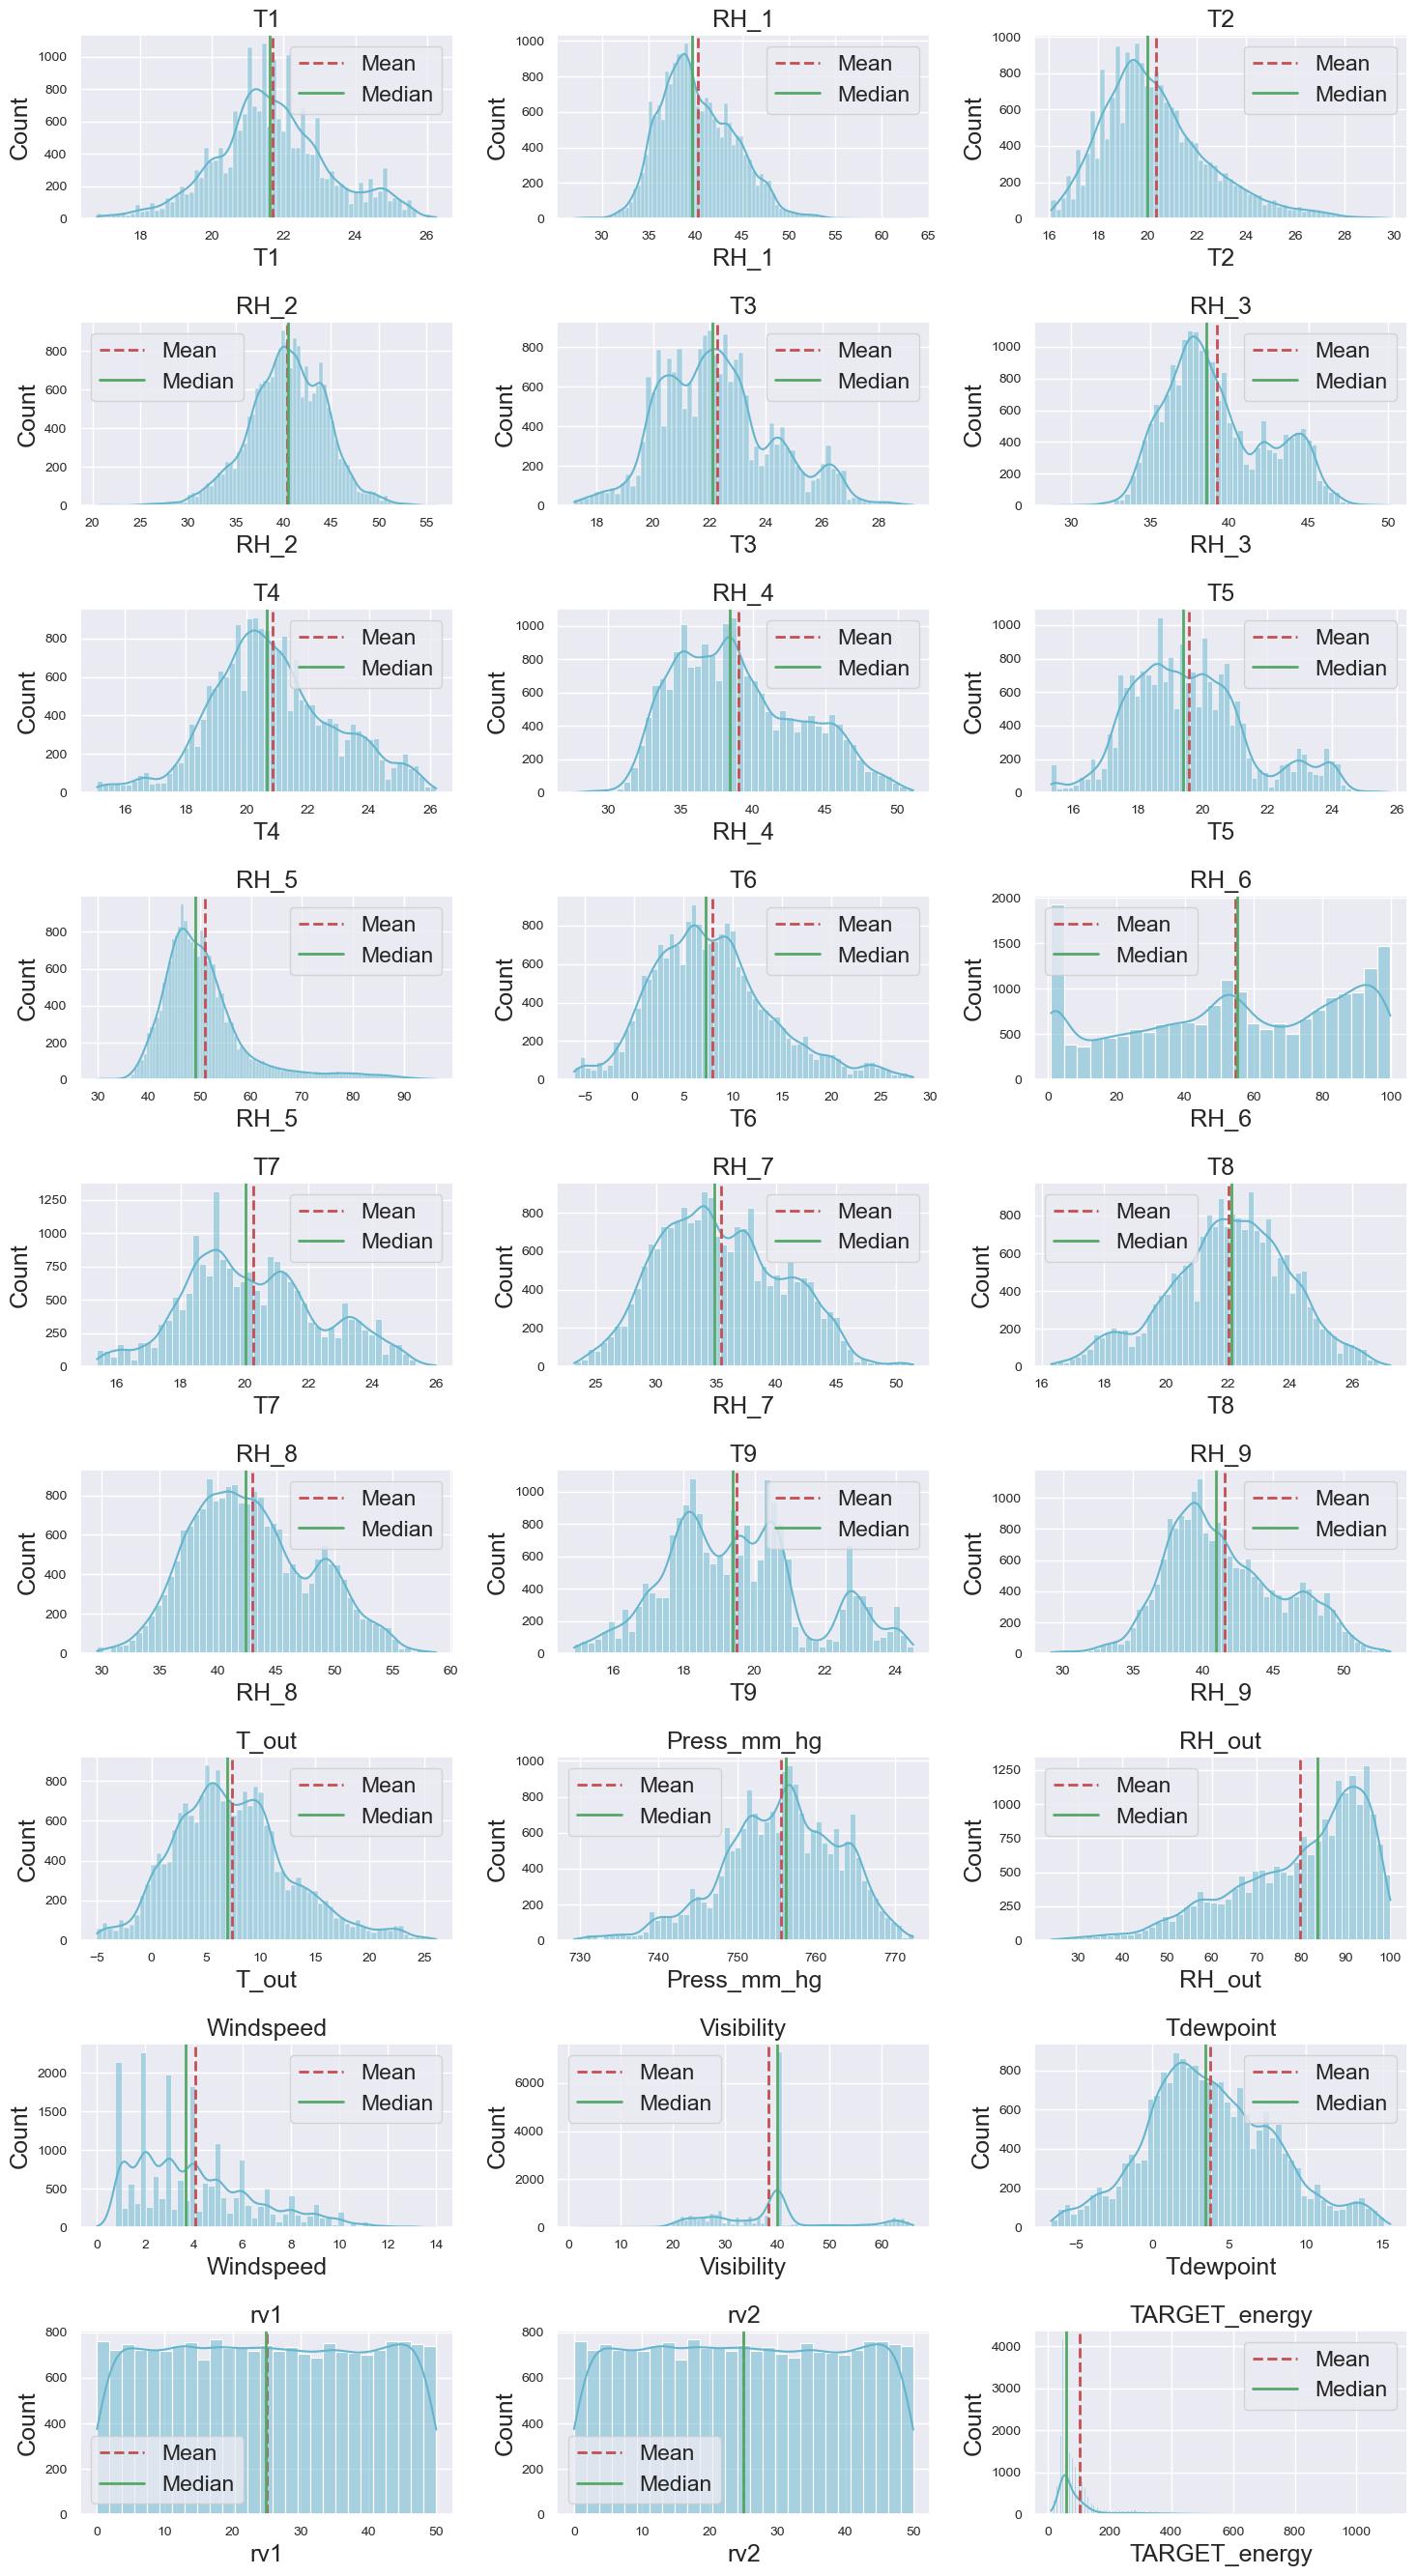

In [35]:
plot_all_histograms_grid()

Text(0.5, 1.0, 'Correlation Matrix of Data')

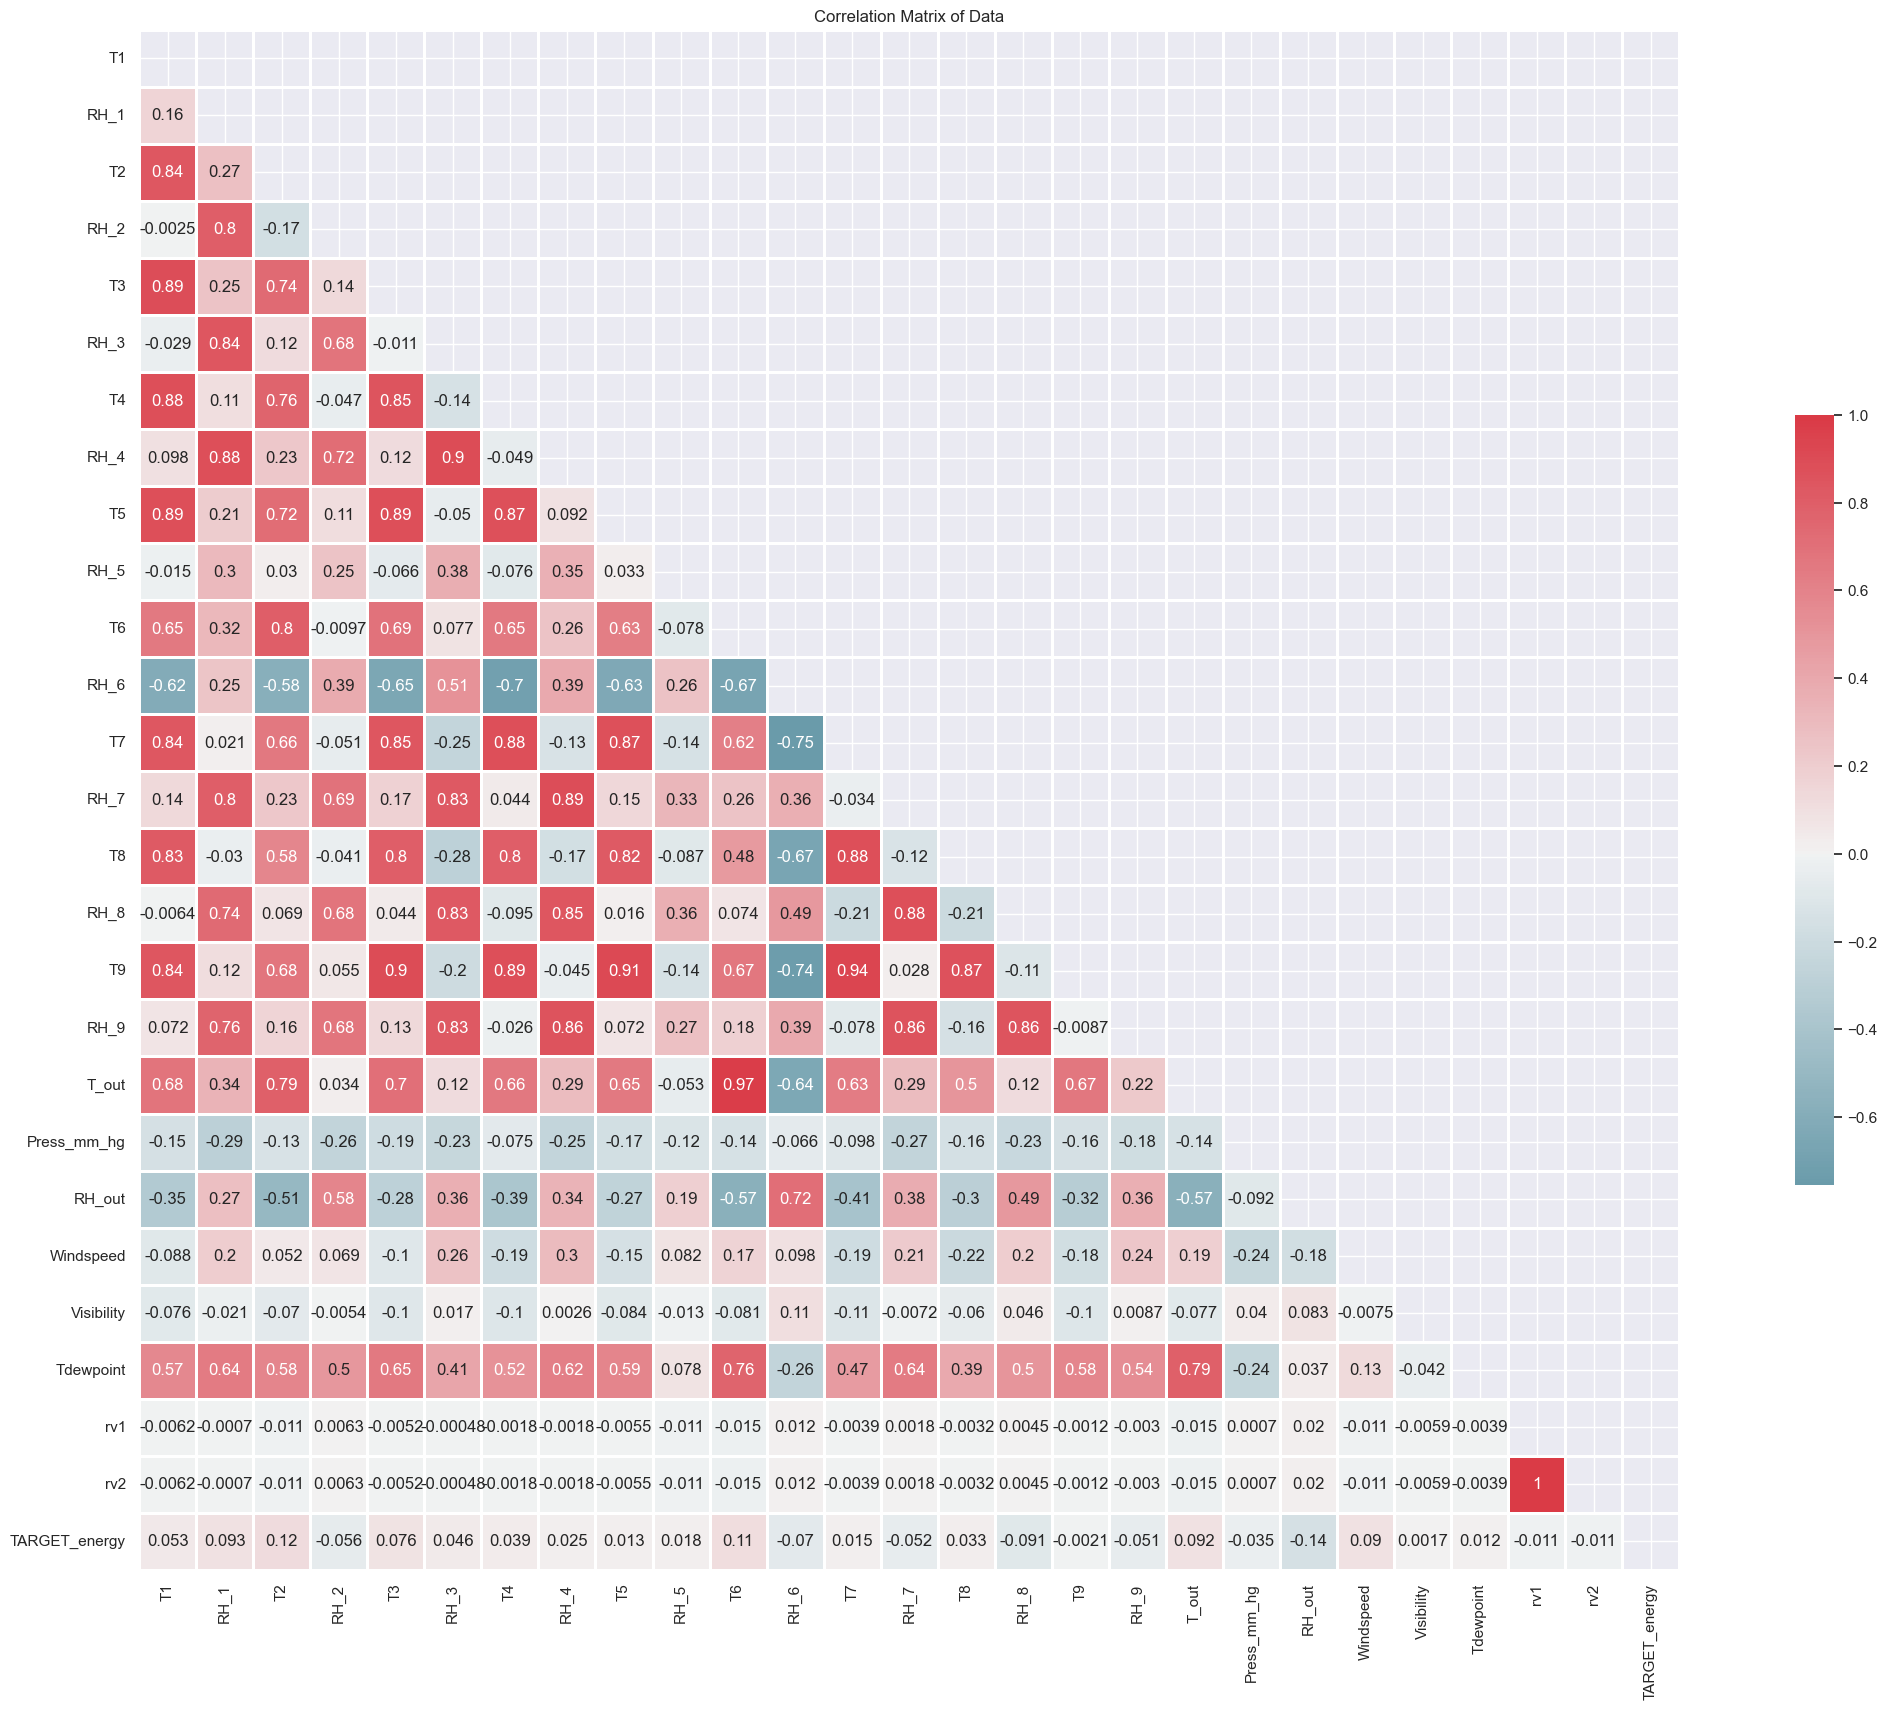

In [49]:
date_removed_df = df.drop(columns=['date'])

corr = date_removed_df.corr()

mask = np.zeros_like(corr, dtype = bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (30, 20))

cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.set(font_scale=1)

sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, center = 0, square = True, 
            linewidths = 1, cbar_kws = {"shrink": .5}, annot = True)
ax.set_title('Correlation Matrix of Data')